In [1]:
import torch
import torch.optim as optim
from torchtext.datasets import Multi30k
import numpy as np
import pandas as pd
import spacy
import random
import re
import string
import torchtext
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 78.2 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
spacy_eng = spacy.load('en_core_web_sm')

In [5]:
batch_size = 32
learning_rate = 3e-4
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
epochs = 15

In [6]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>", 3:"<UNK>"}
        self.stoi = {"<PAD>":0, "<SOS>":1, "<EOS>":2, "<UNK>":3}
        self.freq_threshold  = freq_threshold
        
    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def preprocessing_text(text):
        text = text.lower().strip()
        text = re.sub(f'[{string.punctuation}\n]', '', text)
        return text
    
    @staticmethod
    def tokenizer_eng(text):
        text = Vocabulary.preprocessing_text(text)
        return [tok.text for tok in spacy_eng.tokenizer(text)]
    
    def build_vocabulary(self, sentence_list):
        frequencies = {}
        index = 4
        
        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1
                    
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = index
                    self.itos[index] = word
                    index += 1
                    
    def numericalize(self, text, lang="eng"):
        if lang == "eng":
            tokenized_text = self.tokenizer_eng(text)
        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [7]:
class MyCollate:
    def __init__(self, pad_index):
        self.pad_index = pad_index
        
    def __call__(self, batch):
        questions = [item[0] for item in batch]
        questions = pad_sequence(questions, batch_first=False, padding_value=self.pad_index)
        labels = torch.tensor([item[1] for item in batch])
        return questions, labels

In [8]:
class Quora_Custom(Dataset):
    def __init__(self, csv_file, transform = None, freq_threshold = 5):
        self.csv_file = csv_file
        self.data = pd.read_csv(csv_file)
        self.question = self.data["question_text"]
        self.label = self.data["target"]
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.question.tolist())
        
    def __len__(self):
        return len(self.data)
    
    def vocab_len(self):
        return len(self.vocab)
    
    def __getitem__(self, index):
        question = self.question[index]
        label = self.label[index]
        captions = [self.vocab.stoi["<SOS>"]]
        captions += self.vocab.numericalize(question)
        captions.append(self.vocab.stoi["<EOS>"])
        return (torch.tensor(captions), torch.tensor(label))

In [9]:
dataset = Quora_Custom("/kaggle/input/quorainsincerequestionsclassification/train.csv")
pad_index = dataset.vocab.stoi["<PAD>"]
train_data, test_data = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_loader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=MyCollate(pad_index))
test_loader = DataLoader(test_data, batch_size, shuffle=True, collate_fn=MyCollate(pad_index))

In [44]:
vocab = dataset.vocab
vocab_len = dataset.vocab_len()
input_size = vocab_len
embedding_size = 64
hidden_size = 128
num_layers = 2
dropout = 0.5
output_size = 1

In [45]:
input_size

46793

In [46]:
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_size, embedding_size, num_layers, output_size, p):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.dropout = nn.Dropout(p)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=p, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):   # (batch_size, seq_length)
        x = self.embedding(x)  # (batch_size, seq_length, embedding_size)
        x = self.dropout(x)
        output, (hidden, cell) = self.lstm(x)
        output = output.permute(0, 2, 1)  # (batch_size, hidden_size, seq_length)
        prediction = self.fc(output[:, :, -1])  # (batch_size, output_size)
        prediction = self.sigmoid(prediction)  # (batch_size, output_size)
        return prediction.squeeze(1)  # (batch_size,)

In [47]:
x = torch.randint(0, input_size, (32,14)).to(device)
model = Classifier(input_size, hidden_size, embedding_size, num_layers, output_size, dropout).to(device)
y = model(x)
print(y.shape)

torch.Size([32])


In [48]:
model = Classifier(input_size, hidden_size, embedding_size, num_layers, output_size, dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.BCELoss()

In [49]:
t_loss = []
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device).long()  # Ensure data is of type LongTensor
        label = label.to(device).float()  # Ensure label is of type LongTensor
        data = data.permute(1,0)
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        train_loss += loss.item()
        optimizer.step()
    train_loss /= len(train_loader)
    t_loss.append(train_loss)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}')

Epoch 1, Train Loss: 0.16312145070985867
Epoch 2, Train Loss: 0.1340278120180505
Epoch 3, Train Loss: 0.12423304270018776
Epoch 4, Train Loss: 0.11856950396156227
Epoch 5, Train Loss: 0.11522420360412766
Epoch 6, Train Loss: 0.11269883349097856
Epoch 7, Train Loss: 0.11098344911697378
Epoch 8, Train Loss: 0.10966049505128743
Epoch 9, Train Loss: 0.10853512016530556
Epoch 10, Train Loss: 0.1075013568994239
Epoch 11, Train Loss: 0.10664727254769808
Epoch 12, Train Loss: 0.10595084274744204
Epoch 13, Train Loss: 0.10538937763615429
Epoch 14, Train Loss: 0.10462583859118767
Epoch 15, Train Loss: 0.10409641889471581


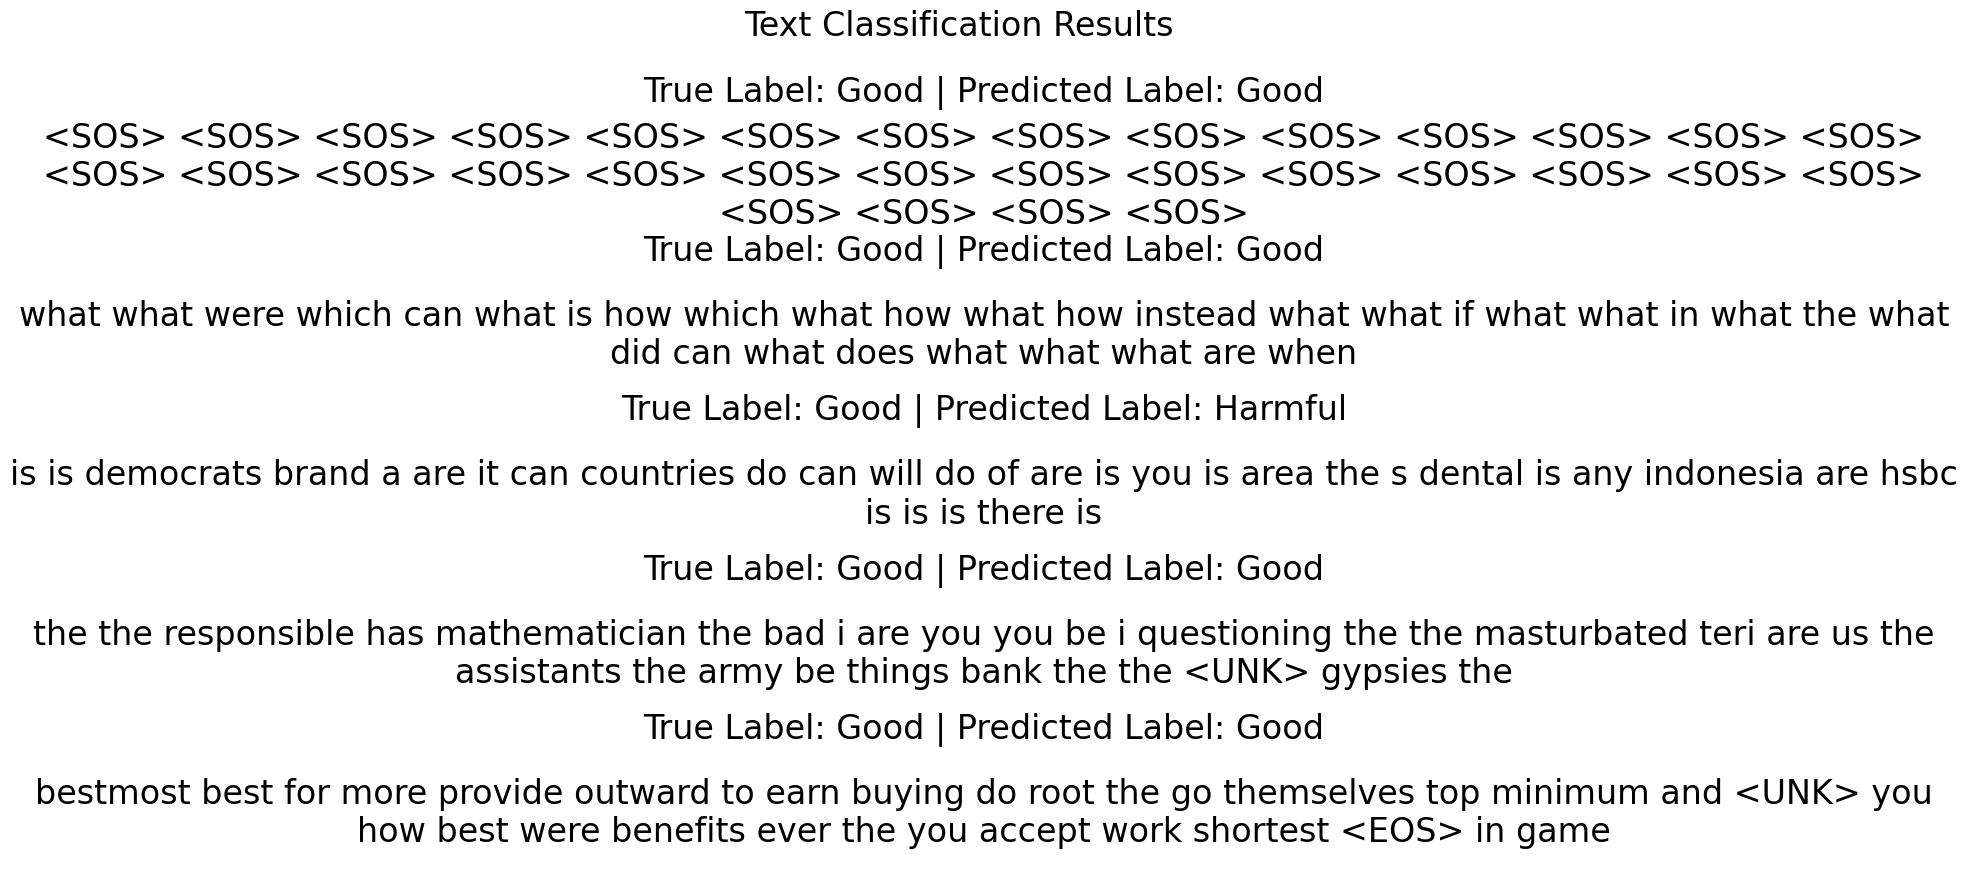

In [60]:
def tensor_to_text(tensor, vocab):
    words = []
    for idx in tensor:
        if idx != pad_index:
            word = vocab.itos.get(idx.item(), "<UNK>")
            words.append(word)
    return ' '.join(words)


data = next(iter(test_loader))
inputs = data[0].to(device)
labels = data[1].to(device)

model.eval()
with torch.no_grad():
    predictions = model(inputs)
    threshold = 0.5
    classified_labels = (predictions >= threshold).long()

# Prepare data for visualization
input_texts = [tensor_to_text(text, dataset.vocab) for text in inputs.cpu()]
true_labels = labels.cpu().numpy()
predicted_labels = classified_labels.cpu().numpy()

# Visualization
num_samples = min(5, len(input_texts))
fig, ax = plt.subplots(num_samples, 1, figsize=(20, num_samples * 2))
fig.suptitle("Text Classification Results", fontsize=24)

for i in range(num_samples):
    ax[i].set_title(f"True Label: {'Harmful' if true_labels[i] == 1 else 'Good'} | Predicted Label: {'Harmful' if predicted_labels[i] == 1 else 'Good'}", fontsize=24)
    ax[i].text(0.5, 0.5, input_texts[i], horizontalalignment='center', verticalalignment='center', fontsize=24, wrap=True)
    ax[i].axis('off')

plt.show()